In [1]:
import pickle
import numpy as np
import os
import torch
import torch.nn as nn
import re
import sys
from copy import deepcopy
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import matplotlib.pyplot as plt
import re
import pandas as pd
import seaborn as sns

root = os.path.dirname(os.path.abspath(os.curdir))
sys.path.append(root)
from sr_model.models.models import AnalyticSR, STDP_SR, Linear, MLP
from datasets import inputs, sf_inputs_discrete
from run_td_rnn import run as run_rnn
from run_td_mlp import run as run_mlp
from run_td_linear import run as run_linear

device = 'cpu'

/home/chingf/Code/sr-project/datasets/inputs.py:12: UserWarning: Emily's experimental data could not be loaded.
  warnings.warn("Emily's experimental data could not be loaded.")
/home/chingf/Code/sr-project/datasets/sf_inputs_discrete.py:14: UserWarning: Emily's experimental data could not be loaded.
  warnings.warn("Emily's experimental data could not be loaded.")


In [93]:
def format_dset_name(key):
    if 'pval50/' in key:
        return '50% Sparsity'
    elif 'pval80/' in key:
        return '80% Sparsity'
    elif 'pval95/' in key:
        return '95% Sparsity'
    elif 'sparse' in key:
        return 'Localized'
    else:
        return 'Unknown'

In [94]:
def get_sigma(key):
    p = re.compile('.*sigma(.+)\/.*')
    if 'sigma' in key:
        m = p.match(key)
        return m.group(1)
    else:
        return '0'

# Helper functions to calculate metrics

In [95]:
from findpeaks import findpeaks
from scipy.ndimage.measurements import label

In [96]:
# Area and Peaks

def get_area_and_peaks(firing_field):
    masked_field = firing_field > 0.8
    labeled_array, ncomponents = label(masked_field, np.ones((3,3)))
    areas = []
    for label_id in np.unique(labeled_array):
        if label_id == 0: continue
        areas.append(np.sum(labeled_array == label_id))
    return areas, ncomponents

# Spatial Info

def flatten_xy(walk_xs, walk_ys):
    max_col = walk_ys.max()
    new_bins = walk_xs * max_col + walk_ys
    return new_bins

def circular(fr):
    """
    Circularly shuffles a (neur, frames) array of firing rates, neuron by neuron.
    """

    fr = fr.copy()
    shift = np.random.choice(np.arange(1, fr.size))
    if len(fr.shape) == 2:
        num_neur, num_frames = fr.shape
        for neur in range(num_neur):
            shift = np.random.choice(np.arange(1, num_frames))
            fr[neur,:] = np.roll(fr[neur,:], shift)
        return fr
    else:
        return np.roll(fr, shift)
    
def get_mutual_info(conditions, fr):
    """
    Calculates mutual information between firing rate and a set of conditions

    Args:
        conditions: (frames,) array of conditions
        fr: (neurs, frames) array of firing rates
    Returns:
        (neurs,) array of scaler value mutual information per neuron
    """

    num_neurs, _ = fr.shape
    mean_fr = np.mean(fr, axis=1)
    mutual_info = np.zeros(num_neurs)
    for condn in np.unique(conditions):
        prob = np.sum(conditions==condn)/conditions.size
        condn_mean_fr = np.mean(fr[:,conditions==condn], axis=1)
        log_term = np.log2(condn_mean_fr/mean_fr)
        log_term[np.isnan(log_term)] = 0
        log_term[np.isinf(log_term)] = 0
        mutual_info += prob*condn_mean_fr*log_term
    return mutual_info

def calc_place_cells(xs, ys, fr, num_shuffles):
    """ Gets the spatial mutual information of each cell."""

    num_neurs, num_frames = fr.shape
    spatial_info = np.zeros(num_neurs)
    significance = np.zeros(num_neurs)
    conditions = flatten_xy(xs, ys)
    spatial_info = get_mutual_info(conditions, fr)
    
    for _ in range(num_shuffles):
        shuffled_fr = circular(fr)
        shuffled_info = get_mutual_info(conditions, shuffled_fr)
        significance += (shuffled_info < spatial_info)
    significance /= num_shuffles
    
    return spatial_info, significance

In [97]:
def get_metrics(outputs, dset):
    walk_xs = dset.xs.astype(int)
    walk_ys = dset.ys.astype(int)
    arena_length = 10
    
    areas = []
    ncomps = []

    spatial_info, significance = calc_place_cells(
        walk_xs, walk_ys, outputs.T, 100
        )

    for neur in np.arange(outputs.shape[1]):
        firing_field = np.zeros((arena_length, arena_length))*np.nan
        for x in range(arena_length):
            for y in range(arena_length):
                frame_idxs = np.logical_and(walk_xs == x, walk_ys == y)
                fr = np.nanmean(outputs[frame_idxs, neur])
                firing_field[x,y] = fr
        firing_field[np.isnan(firing_field)] = 0

        # Area?
        area, ncomp = get_area_and_peaks(firing_field)
        areas.append(np.sum(area))
        ncomps.append(ncomp)
    return np.array(areas), np.array(ncomps), spatial_info

# Plot aggregate metrics
From Henrikson & Mosers, 2010: "A place field was estimated as a contiguous region of at least 225 cm2 (9 or more 5 cm × 5 cm bins) where the firing rate was above 20% of the peak rate and the peak firing rate of the area was 0.25 Hz or higher. The number of nonoverlapping place fields was estimated for each cell. "

# Run each dataset

In [98]:
root_dir = "../trained_models/"
dset_dirs = [
    '03_td_discrete_uncorr/pval50/',
    '03_td_discrete_uncorr/pval80/',
    '03_td_discrete_uncorr/pval95/',
    '03_td_discrete_corr/pval50_sigma1.0/',
    '03_td_discrete_corr/pval50_sigma1.25/',
    '03_td_discrete_corr/pval50_sigma1.5/',
    '03_td_discrete_corr/pval50_sigma1.75/',
    '03_td_discrete_corr/pval50_sigma2.0/',
    '03_td_discrete_corr/pval80_sigma1.0/',
    '03_td_discrete_corr/pval80_sigma1.25/',
    '03_td_discrete_corr/pval80_sigma1.5/',
    '03_td_discrete_corr/pval80_sigma1.75/',
    '03_td_discrete_corr/pval80_sigma2.0/',
    '03_td_discrete_corr/pval95_sigma1.0/',
    '03_td_discrete_corr/pval95_sigma1.25/',
    '03_td_discrete_corr/pval95_sigma1.5/',
    '03_td_discrete_corr/pval95_sigma1.75/',
    '03_td_discrete_corr/pval95_sigma2.0/',
    '03_td_discrete_corr/sparse_sigma1.0/',
    '03_td_discrete_corr/sparse_sigma1.25/',
    '03_td_discrete_corr/sparse_sigma1.5/',
    '03_td_discrete_corr/sparse_sigma1.75/',
    ]

gamma = 0.6

dset_names = []
sigmas = []
field_areas = []
field_nums = []
p_one_field = []
spatial_infos = []

for dset_dir in dset_dirs:
    dset_name = format_dset_name(dset_dir)
    sigma = get_sigma(dset_dir)
    gamma_dir = f'{root_dir}{dset_dir}{gamma}/'
    model_dir = f'{gamma_dir}rnn_fixedlr_alpha/'
    for _iter in os.listdir(model_dir):
        iter_dir = model_dir + _iter + '/'
        results_path = iter_dir + 'results.p'
        with open(results_path, 'rb') as f:
            results = pickle.load(f)
        outputs = results['outputs']
        dset = results['dset']
        areas, ncomps, spatial_info = get_metrics(outputs, dset)
        dset_names.append(dset_name)
        sigmas.append(sigma)
        field_areas.append(np.median(areas)/100)
        field_nums.append(np.median(ncomps))
        p_one_field.append(np.sum(ncomps==1)/ncomps.size)
        spatial_infos.append(np.mean(spatial_info))

/home/chingf/anaconda3/envs/aronov/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: divide by zero encountered in log2
/home/chingf/anaconda3/envs/aronov/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in log2
/home/chingf/anaconda3/envs/aronov/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in true_divide


# Make barplots

In [87]:
df = pd.DataFrame({
    'Dataset': dset_names,
    'Sigma': sigmas,
    'Field Area': field_areas,
    'Number of Fields': field_nums,
    'Proportion with One Field': p_one_field,
    'Spatial Information': spatial_infos
    })

In [88]:
dset_fontsize = 12
xylabel_fontsize = 16

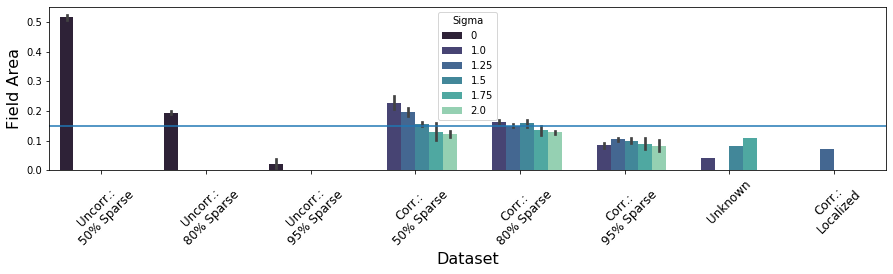

In [90]:
fig, ax = plt.subplots(figsize=(15,3))
sns.barplot(
    x='Dataset', y='Field Area',
    hue='Sigma', palette='mako',
    ax=ax, data=df
    )
plt.ylabel('Field Area', fontsize=xylabel_fontsize)
plt.xlabel('Dataset', fontsize=xylabel_fontsize)
plt.xticks(rotation=45, fontsize=dset_fontsize)
plt.axhline(0.15)
plt.show()

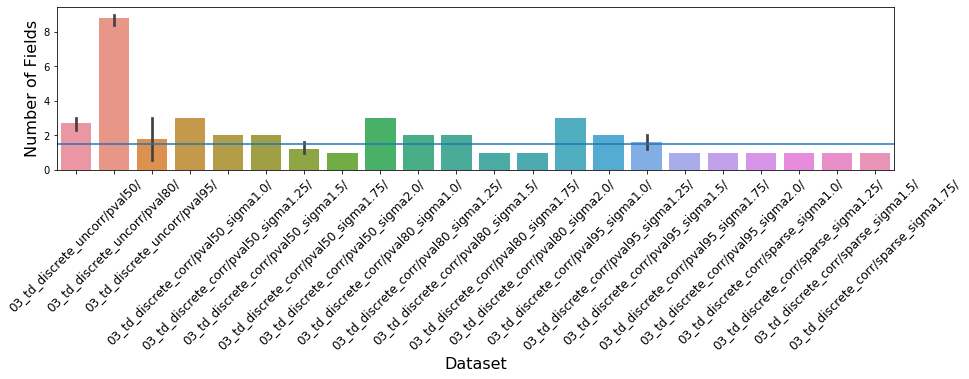

In [51]:
fig, ax = plt.subplots(figsize=(15,3))
sns.barplot(
    x='Dataset', y='Number of Fields', ax=ax, data=df
    )
plt.ylabel('Number of Fields', fontsize=xylabel_fontsize)
plt.xlabel('Dataset', fontsize=xylabel_fontsize)
plt.xticks(rotation=45, fontsize=dset_fontsize)
plt.axhline(1.5)
plt.show()

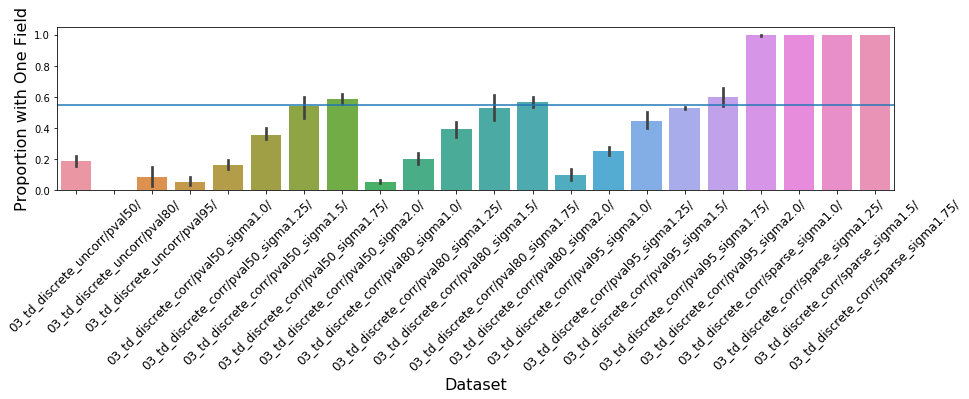

In [52]:
fig, ax = plt.subplots(figsize=(15,3))
sns.barplot(
    x='Dataset', y='Proportion with One Field', ax=ax, data=df
    )
plt.ylabel('Proportion with One Field', fontsize=xylabel_fontsize)
plt.xlabel('Dataset', fontsize=xylabel_fontsize)
plt.xticks(rotation=45, fontsize=dset_fontsize)
plt.axhline(0.55)
plt.show()

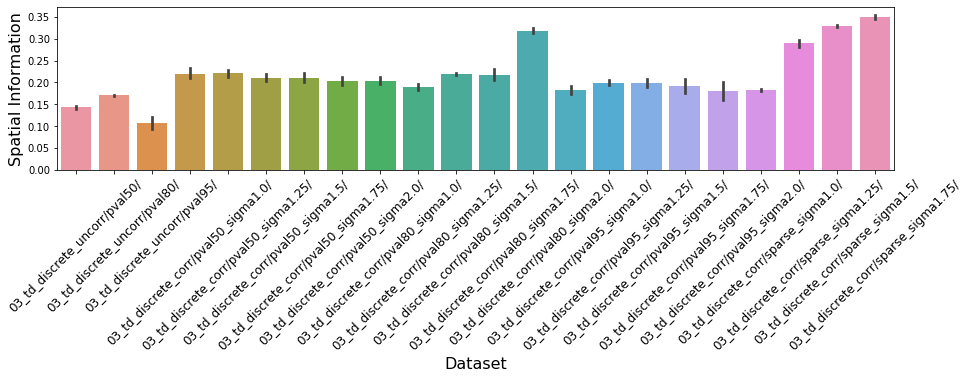

In [53]:
fig, ax = plt.subplots(figsize=(15,3))
sns.barplot(
    x='Dataset', y='Spatial Information', ax=ax, data=df
    )
plt.ylabel('Spatial Information', fontsize=xylabel_fontsize)
plt.xlabel('Dataset', fontsize=xylabel_fontsize)
plt.xticks(rotation=45, fontsize=dset_fontsize)
plt.show()

# Gamma = 0.4

In [54]:
root_dir = "../trained_models/"
dset_dirs = [
    '03_td_discrete_uncorr/pval50/',
    '03_td_discrete_uncorr/pval80/',
    '03_td_discrete_uncorr/pval95/',
    '03_td_discrete_corr/pval50_sigma1.0/',
    '03_td_discrete_corr/pval50_sigma1.25/',
    '03_td_discrete_corr/pval50_sigma1.5/',
    '03_td_discrete_corr/pval50_sigma1.75/',
    '03_td_discrete_corr/pval50_sigma2.0/',
    '03_td_discrete_corr/pval80_sigma1.0/',
    '03_td_discrete_corr/pval80_sigma1.25/',
    '03_td_discrete_corr/pval80_sigma1.5/',
    '03_td_discrete_corr/pval80_sigma1.75/',
    '03_td_discrete_corr/pval80_sigma2.0/',
    '03_td_discrete_corr/pval95_sigma1.0/',
    '03_td_discrete_corr/pval95_sigma1.25/',
    '03_td_discrete_corr/pval95_sigma1.5/',
    '03_td_discrete_corr/pval95_sigma1.75/',
    '03_td_discrete_corr/pval95_sigma2.0/',
    '03_td_discrete_corr/sparse_sigma1.0/',
    '03_td_discrete_corr/sparse_sigma1.25/',
    '03_td_discrete_corr/sparse_sigma1.5/',
    '03_td_discrete_corr/sparse_sigma1.75/',
    ]

gamma = 0.4

dset_names = []
field_areas = []
field_nums = []
p_one_field = []
spatial_infos = []

for dset_dir in dset_dirs:
    dset_name = format_dset_name(dset_dir)
    gamma_dir = f'{root_dir}{dset_dir}{gamma}/'
    model_dir = f'{gamma_dir}rnn_fixedlr_alpha/'
    for _iter in os.listdir(model_dir):
        iter_dir = model_dir + _iter + '/'
        results_path = iter_dir + 'results.p'
        with open(results_path, 'rb') as f:
            results = pickle.load(f)
        outputs = results['outputs']
        dset = results['dset']
        areas, ncomps, spatial_info = get_metrics(outputs, dset)
        dset_names.append(dset_name)
        field_areas.append(np.median(areas)/100)
        field_nums.append(np.median(ncomps))
        p_one_field.append(np.sum(ncomps==1)/ncomps.size)
        spatial_infos.append(np.mean(spatial_info))

/home/chingf/anaconda3/envs/aronov/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in log2
/home/chingf/anaconda3/envs/aronov/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: divide by zero encountered in log2
/home/chingf/anaconda3/envs/aronov/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in true_divide


In [55]:
df = pd.DataFrame({
    'Dataset': dset_names,
    'Field Area': field_areas,
    'Number of Fields': field_nums,
    'Proportion with One Field': p_one_field,
    'Spatial Information': spatial_infos
    })

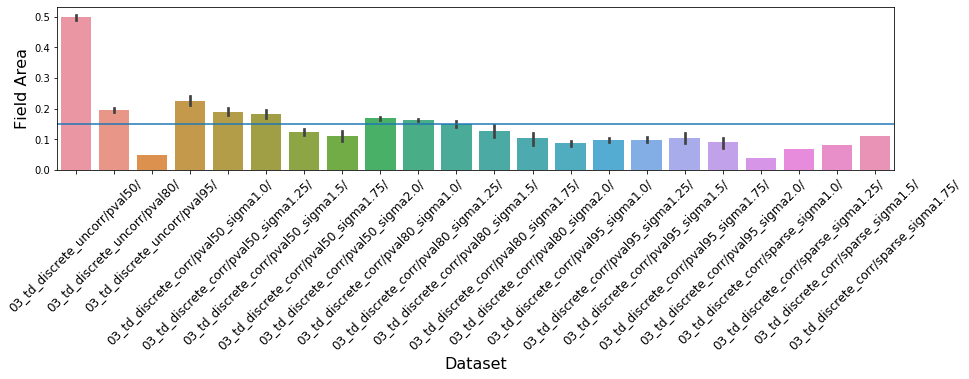

In [57]:
fig, ax = plt.subplots(figsize=(15,3))
sns.barplot(
    x='Dataset', y='Field Area', ax=ax, data=df
    )
plt.ylabel('Field Area', fontsize=xylabel_fontsize)
plt.xlabel('Dataset', fontsize=xylabel_fontsize)
plt.xticks(rotation=45, fontsize=dset_fontsize)
plt.axhline(0.15)
plt.show()

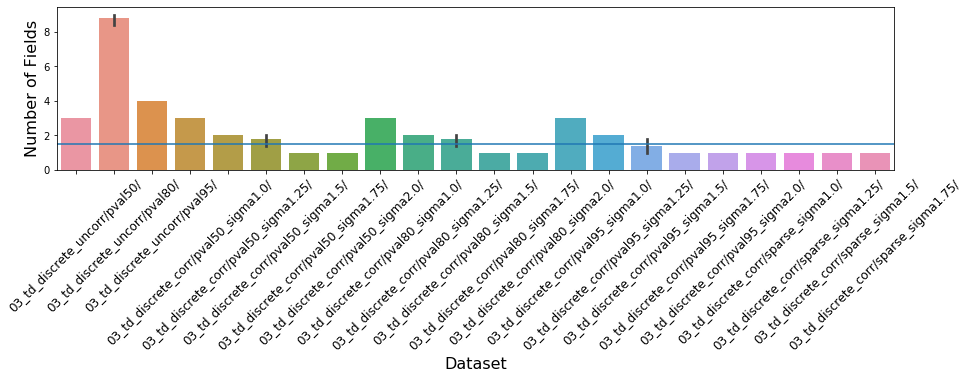

In [58]:
fig, ax = plt.subplots(figsize=(15,3))
sns.barplot(
    x='Dataset', y='Number of Fields', ax=ax, data=df
    )
plt.ylabel('Number of Fields', fontsize=xylabel_fontsize)
plt.xlabel('Dataset', fontsize=xylabel_fontsize)
plt.xticks(rotation=45, fontsize=dset_fontsize)
plt.axhline(1.5)
plt.show()

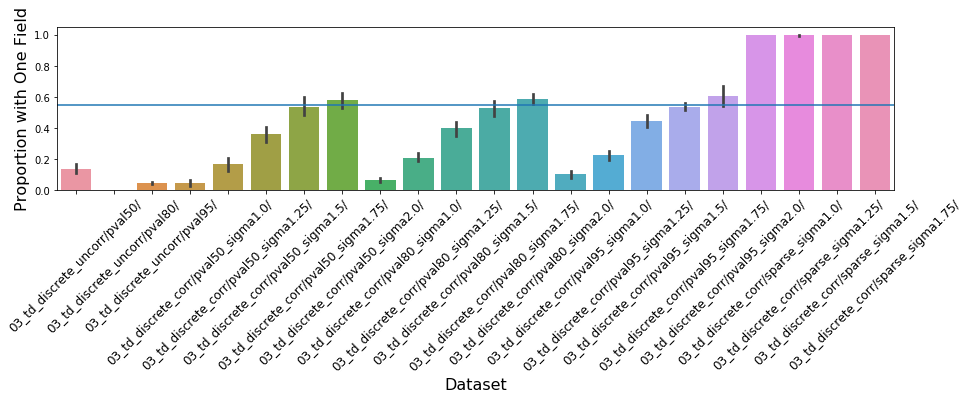

In [59]:
fig, ax = plt.subplots(figsize=(15,3))
sns.barplot(
    x='Dataset', y='Proportion with One Field', ax=ax, data=df
    )
plt.ylabel('Proportion with One Field', fontsize=xylabel_fontsize)
plt.xlabel('Dataset', fontsize=xylabel_fontsize)
plt.xticks(rotation=45, fontsize=dset_fontsize)
plt.axhline(0.55)
plt.show()

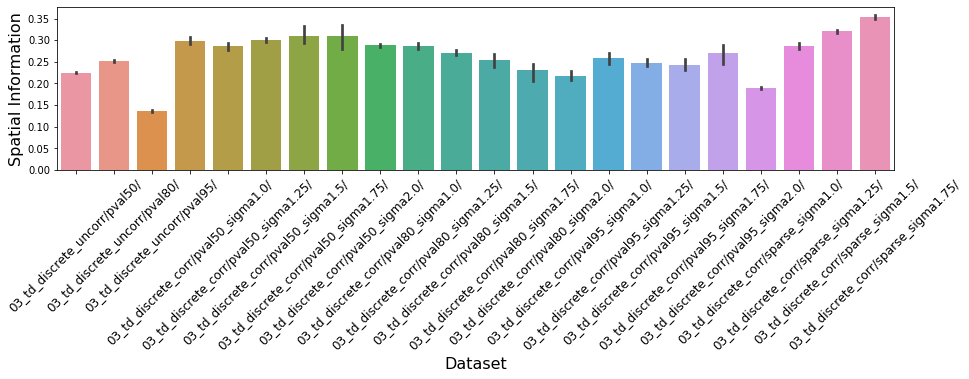

In [60]:
fig, ax = plt.subplots(figsize=(15,3))
sns.barplot(
    x='Dataset', y='Spatial Information', ax=ax, data=df
    )
plt.ylabel('Spatial Information', fontsize=xylabel_fontsize)
plt.xlabel('Dataset', fontsize=xylabel_fontsize)
plt.xticks(rotation=45, fontsize=dset_fontsize)
plt.show()

# Gamma = 0.8

In [61]:
root_dir = "../trained_models/"
dset_dirs = [
    '03_td_discrete_uncorr/pval50/',
    '03_td_discrete_uncorr/pval80/',
    '03_td_discrete_uncorr/pval95/',
    '03_td_discrete_corr/pval50_sigma1.0/',
    '03_td_discrete_corr/pval50_sigma1.25/',
    '03_td_discrete_corr/pval50_sigma1.5/',
    '03_td_discrete_corr/pval50_sigma1.75/',
    '03_td_discrete_corr/pval50_sigma2.0/',
    '03_td_discrete_corr/pval80_sigma1.0/',
    '03_td_discrete_corr/pval80_sigma1.25/',
    '03_td_discrete_corr/pval80_sigma1.5/',
    '03_td_discrete_corr/pval80_sigma1.75/',
    '03_td_discrete_corr/pval80_sigma2.0/',
    '03_td_discrete_corr/pval95_sigma1.0/',
    '03_td_discrete_corr/pval95_sigma1.25/',
    '03_td_discrete_corr/pval95_sigma1.5/',
    '03_td_discrete_corr/pval95_sigma1.75/',
    '03_td_discrete_corr/pval95_sigma2.0/',
    '03_td_discrete_corr/sparse_sigma1.0/',
    '03_td_discrete_corr/sparse_sigma1.25/',
    '03_td_discrete_corr/sparse_sigma1.5/',
    '03_td_discrete_corr/sparse_sigma1.75/',
    ]

gamma = 0.8

dset_names = []
field_areas = []
field_nums = []
p_one_field = []
spatial_infos = []

for dset_dir in dset_dirs:
    dset_name = format_dset_name(dset_dir)
    gamma_dir = f'{root_dir}{dset_dir}{gamma}/'
    model_dir = f'{gamma_dir}rnn_fixedlr_alpha/'
    for _iter in os.listdir(model_dir):
        iter_dir = model_dir + _iter + '/'
        results_path = iter_dir + 'results.p'
        with open(results_path, 'rb') as f:
            results = pickle.load(f)
        outputs = results['outputs']
        dset = results['dset']
        areas, ncomps, spatial_info = get_metrics(outputs, dset)
        dset_names.append(dset_name)
        field_areas.append(np.median(areas)/100)
        field_nums.append(np.median(ncomps))
        p_one_field.append(np.sum(ncomps==1)/ncomps.size)
        spatial_infos.append(np.mean(spatial_info))

/home/chingf/anaconda3/envs/aronov/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: divide by zero encountered in log2
/home/chingf/anaconda3/envs/aronov/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in log2
/home/chingf/anaconda3/envs/aronov/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in true_divide


In [62]:
df = pd.DataFrame({
    'Dataset': dset_names,
    'Field Area': field_areas,
    'Number of Fields': field_nums,
    'Proportion with One Field': p_one_field,
    'Spatial Information': spatial_infos
    })

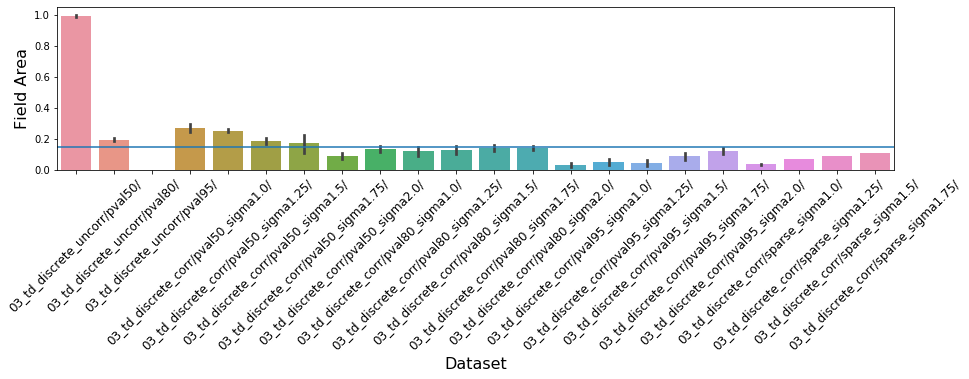

In [63]:
fig, ax = plt.subplots(figsize=(15,3))
sns.barplot(
    x='Dataset', y='Field Area', ax=ax, data=df
    )
plt.ylabel('Field Area', fontsize=xylabel_fontsize)
plt.xlabel('Dataset', fontsize=xylabel_fontsize)
plt.xticks(rotation=45, fontsize=dset_fontsize)
plt.axhline(0.15)
plt.show()

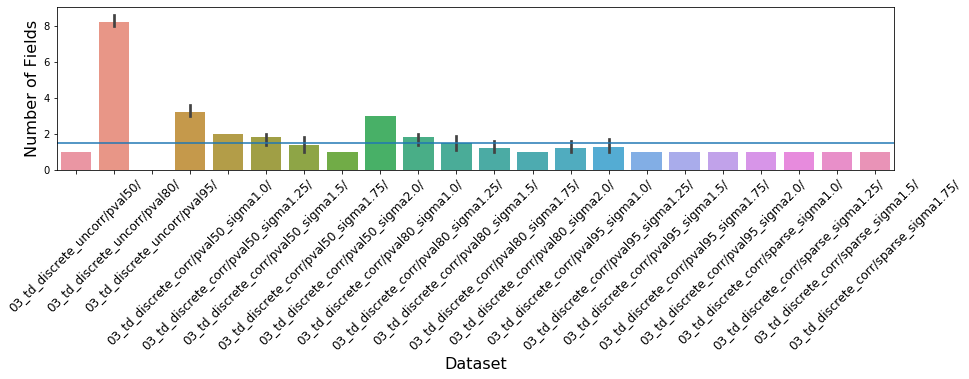

In [64]:
fig, ax = plt.subplots(figsize=(15,3))
sns.barplot(
    x='Dataset', y='Number of Fields', ax=ax, data=df
    )
plt.ylabel('Number of Fields', fontsize=xylabel_fontsize)
plt.xlabel('Dataset', fontsize=xylabel_fontsize)
plt.xticks(rotation=45, fontsize=dset_fontsize)
plt.axhline(1.5)
plt.show()

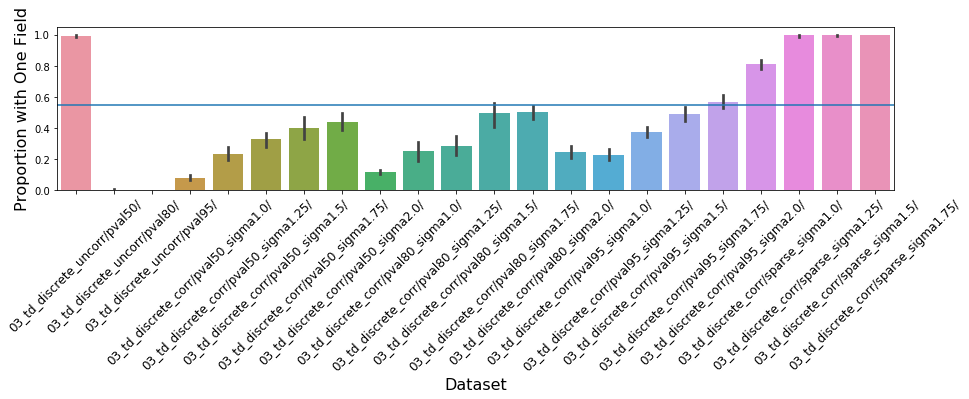

In [65]:
fig, ax = plt.subplots(figsize=(15,3))
sns.barplot(
    x='Dataset', y='Proportion with One Field', ax=ax, data=df
    )
plt.ylabel('Proportion with One Field', fontsize=xylabel_fontsize)
plt.xlabel('Dataset', fontsize=xylabel_fontsize)
plt.xticks(rotation=45, fontsize=dset_fontsize)
plt.axhline(0.55)
plt.show()

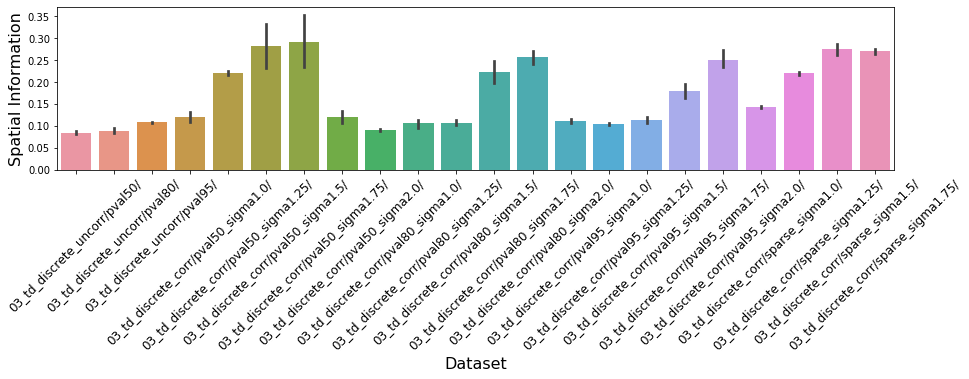

In [66]:
fig, ax = plt.subplots(figsize=(15,3))
sns.barplot(
    x='Dataset', y='Spatial Information', ax=ax, data=df
    )
plt.ylabel('Spatial Information', fontsize=xylabel_fontsize)
plt.xlabel('Dataset', fontsize=xylabel_fontsize)
plt.xticks(rotation=45, fontsize=dset_fontsize)
plt.show()

# Gamma = 0.95

In [67]:
root_dir = "../trained_models/"
dset_dirs = [
    '03_td_discrete_uncorr/pval50/',
    '03_td_discrete_uncorr/pval80/',
    '03_td_discrete_uncorr/pval95/',
    '03_td_discrete_corr/pval50_sigma1.0/',
    '03_td_discrete_corr/pval50_sigma1.25/',
    '03_td_discrete_corr/pval50_sigma1.5/',
    '03_td_discrete_corr/pval50_sigma1.75/',
    '03_td_discrete_corr/pval50_sigma2.0/',
    '03_td_discrete_corr/pval80_sigma1.0/',
    '03_td_discrete_corr/pval80_sigma1.25/',
    '03_td_discrete_corr/pval80_sigma1.5/',
    '03_td_discrete_corr/pval80_sigma1.75/',
    '03_td_discrete_corr/pval80_sigma2.0/',
    '03_td_discrete_corr/pval95_sigma1.0/',
    '03_td_discrete_corr/pval95_sigma1.25/',
    '03_td_discrete_corr/pval95_sigma1.5/',
    '03_td_discrete_corr/pval95_sigma1.75/',
    '03_td_discrete_corr/pval95_sigma2.0/',
    '03_td_discrete_corr/sparse_sigma1.0/',
    '03_td_discrete_corr/sparse_sigma1.25/',
    '03_td_discrete_corr/sparse_sigma1.5/',
    '03_td_discrete_corr/sparse_sigma1.75/',
    ]

gamma = 0.95

dset_names = []
field_areas = []
field_nums = []
p_one_field = []
spatial_infos = []

for dset_dir in dset_dirs:
    dset_name = format_dset_name(dset_dir)
    gamma_dir = f'{root_dir}{dset_dir}{gamma}/'
    model_dir = f'{gamma_dir}rnn_fixedlr_alpha/'
    for _iter in os.listdir(model_dir):
        iter_dir = model_dir + _iter + '/'
        results_path = iter_dir + 'results.p'
        with open(results_path, 'rb') as f:
            results = pickle.load(f)
        outputs = results['outputs']
        dset = results['dset']
        areas, ncomps, spatial_info = get_metrics(outputs, dset)
        dset_names.append(dset_name)
        field_areas.append(np.median(areas)/100)
        field_nums.append(np.median(ncomps))
        p_one_field.append(np.sum(ncomps==1)/ncomps.size)
        spatial_infos.append(np.mean(spatial_info))

/home/chingf/anaconda3/envs/aronov/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in log2
/home/chingf/anaconda3/envs/aronov/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: divide by zero encountered in log2
/home/chingf/anaconda3/envs/aronov/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in true_divide


In [68]:
df = pd.DataFrame({
    'Dataset': dset_names,
    'Field Area': field_areas,
    'Number of Fields': field_nums,
    'Proportion with One Field': p_one_field,
    'Spatial Information': spatial_infos
    })

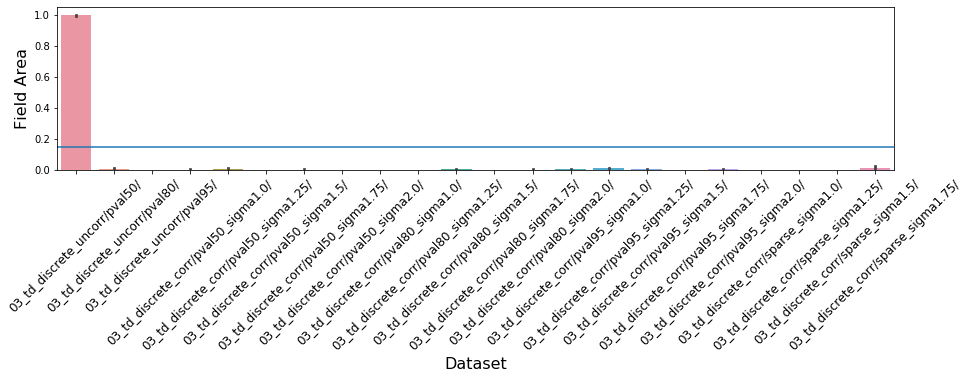

In [69]:
fig, ax = plt.subplots(figsize=(15,3))
sns.barplot(
    x='Dataset', y='Field Area', ax=ax, data=df
    )
plt.ylabel('Field Area', fontsize=xylabel_fontsize)
plt.xlabel('Dataset', fontsize=xylabel_fontsize)
plt.xticks(rotation=45, fontsize=dset_fontsize)
plt.axhline(0.15)
plt.show()

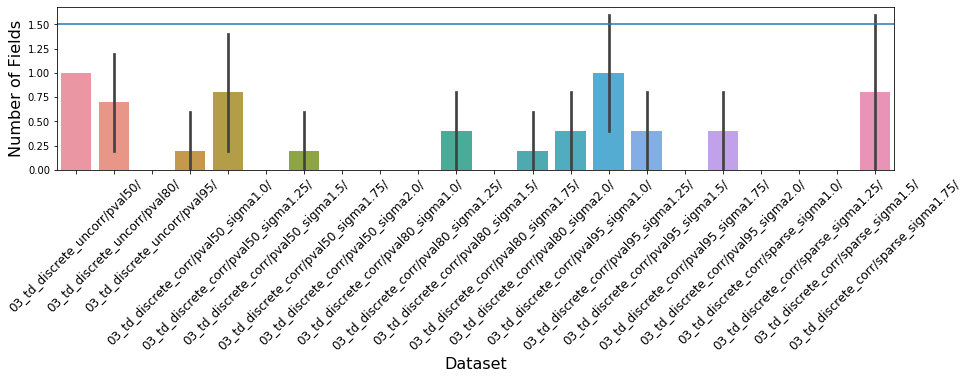

In [70]:
fig, ax = plt.subplots(figsize=(15,3))
sns.barplot(
    x='Dataset', y='Number of Fields', ax=ax, data=df
    )
plt.ylabel('Number of Fields', fontsize=xylabel_fontsize)
plt.xlabel('Dataset', fontsize=xylabel_fontsize)
plt.xticks(rotation=45, fontsize=dset_fontsize)
plt.axhline(1.5)
plt.show()

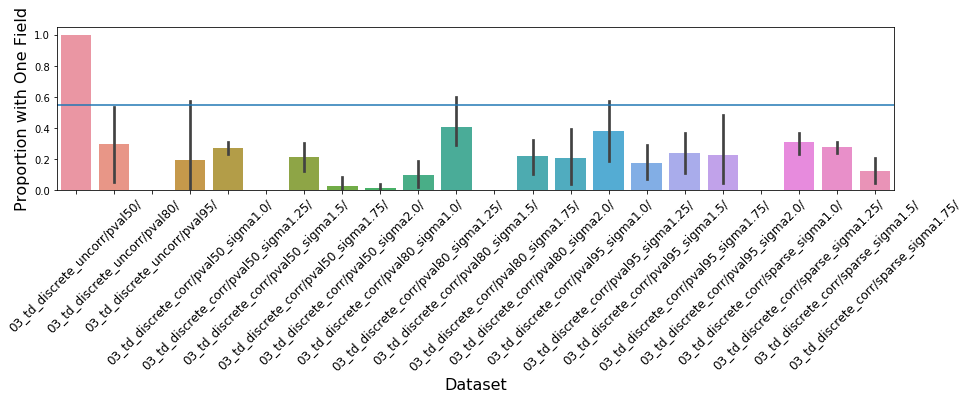

In [71]:
fig, ax = plt.subplots(figsize=(15,3))
sns.barplot(
    x='Dataset', y='Proportion with One Field', ax=ax, data=df
    )
plt.ylabel('Proportion with One Field', fontsize=xylabel_fontsize)
plt.xlabel('Dataset', fontsize=xylabel_fontsize)
plt.xticks(rotation=45, fontsize=dset_fontsize)
plt.axhline(0.55)
plt.show()

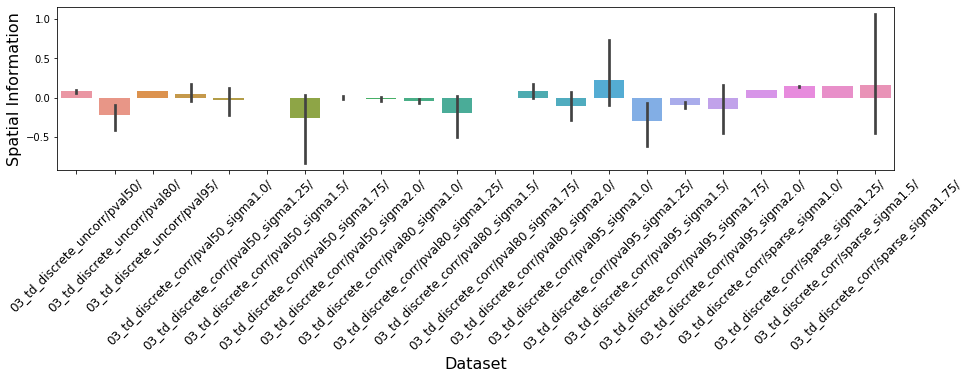

In [72]:
fig, ax = plt.subplots(figsize=(15,3))
sns.barplot(
    x='Dataset', y='Spatial Information', ax=ax, data=df
    )
plt.ylabel('Spatial Information', fontsize=xylabel_fontsize)
plt.xlabel('Dataset', fontsize=xylabel_fontsize)
plt.xticks(rotation=45, fontsize=dset_fontsize)
plt.show()